In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')
import plugins


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [2]:
# Simple code to test the implementation
bsdf = plugins.RednerMat(mi.Properties())
print(bsdf) # Show the default parameters

RednerMat[
    albedo=UniformSpectrum[value=[0.1]],
    roughness=UniformSpectrum[value=[0.1]],
    specular=UniformSpectrum[value=[0.1]],
]


In [3]:
# Simple test of eval, pdf and samples

# Test with fake intersection
si = dr.zeros(mi.SurfaceInteraction3f)
si.wi = mi.Vector3f([0, 0, 1])
ctx = mi.BSDFContext()

# Call eval, pdf, samples
print(bsdf.eval(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.pdf(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.sample(ctx, si, 0.5, mi.Point2f(0.5)))

[[0.11140845715999603, 0.11140845715999603, 0.11140845715999603]]
[0.5570423007011414]
BSDFSample[
  wo = [[-0.49993, -4.37053e-08, 0.866066]],
  pdf = [0.351061],
  eta = [1],
  sampled_type = TODO,
  sampled_component = [0]
]
(BSDFSample[
  wo = [[-0.49993, -4.37053e-08, 0.866066]],
  pdf = [0.351061],
  eta = [1],
  sampled_type = TODO,
  sampled_component = [0]
], [[0.20000004768371582, 0.20000004768371582, 0.20000004768371582]])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Code which will plot the eval and PDF distribution
def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

def plot_dist(values):
    """values needs to be an numpy float array"""
    values_r = values.reshape(2 * res, res).T

    # Plot values for spherical coordinates
    fig, ax = plt.subplots(figsize=(8, 4))

    im = ax.imshow(values_r, extent=[0, 2 * np.pi, np.pi, 0], cmap='jet')

    ax.set_xlabel(r'$\phi_o$', size=10)
    ax.set_xticks([0, dr.pi, dr.two_pi])
    ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
    ax.set_ylabel(r'$\theta_o$', size=10)
    ax.set_yticks([0, dr.pi / 2, dr.pi])
    ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);

si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(dr.deg2rad(45.0), 0.0)

# Create grid in spherical coordinates and map it onto the sphere
res = 300
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

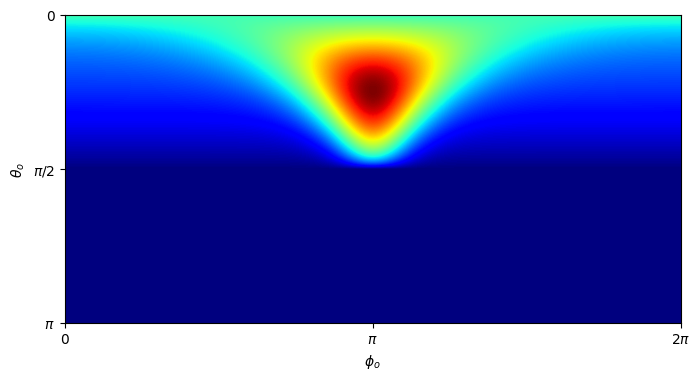

In [5]:
# Plot eval
plot_dist(np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0])


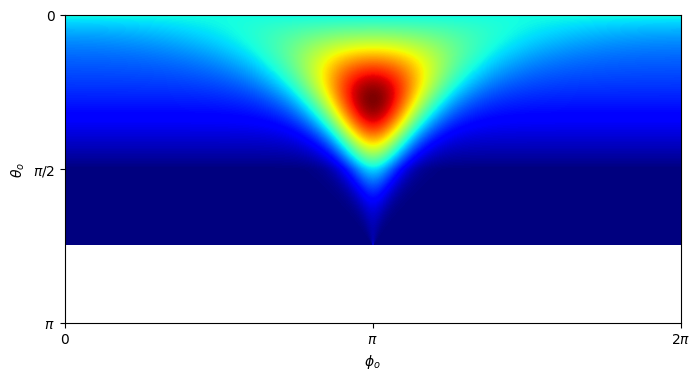

In [6]:
# Plot eval
plot_dist(np.array(bsdf.pdf(mi.BSDFContext(), si, wo)))

In [7]:
# <float name="roughness" value="0.05"/>
# <rgb name="albedo" value="1.0"/>
# <rgb name="specular" value="0.0"/>
xml = """""" 
sample_func, pdf_func = mi.chi2.BSDFAdapter("rednermat", xml)

chi2 = mi.chi2.ChiSquareTest(
    domain=mi.chi2.SphericalDomain(),
    sample_func=sample_func,
    pdf_func=pdf_func,
    sample_dim=3, # 3 random numbers
    ires=16,
    res=201
)

assert chi2.run()

chi2._dump_tables()

BSDFSample[
  wo = [[0.20979, 0.168396, 0.963136],
 [0.287221, 0.339563, 0.895657],
 [0.350715, -0.420428, 0.836803],
 [-0.23218, 0.274619, 0.933101],
 [-0.0905755, 0.78885, 0.607875],
 .. 999990 skipped ..,
 [0.428997, 0.332231, 0.839991],
 [0.454865, -0.271274, 0.848239],
 [-0.157611, -0.553054, 0.818102],
 [-0.490846, -0.571726, 0.657419],
 [-0.47403, -0.619641, 0.625572]],
  pdf = [0.489833, 0.388204, 0.318131, 0.441449, 0.152562, .. 999990 skipped .., 0.321547, 0.330576, 0.298881, 0.177978, 0.161158],
  eta = [1],
  sampled_type = TODO,
  sampled_component = [0]
]
Pooled 10500 low-valued cells into 276 cells to ensure sufficiently high expected cell frequencies
Histogram sum = 0.999487 (22.00 ms), PDF sum = 0.999975 (98.02 ms)
Chi^2 statistic = 10093.549474 (d.o.f = 9875)
Accepted the null hypothesis (p-value = 0.060747, significance level = 0.010000)

